# Fine Tunning com lista de produtos

Este notebook realiza o fine-tuning de um modelo pre-treinado, a partir de um dataset que contem uma lista de produtos existentes no site da amazon.
O resultado esperado é que após o treinamento, o modelo seja capaz de responder corretamente as perguntas realizadas sobre os determinados produtos pertecentes ao dataset treinado.


Monta o drive para acesso aos arquivos.

In [24]:
# Mount the drive to persit the model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Instalação das dependencias

In [25]:
# Install the modules
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers==0.0.27 "trl<0.9.0" peft accelerate bitsandbytes # Downgrade xformers to 0.0.27
!pip install transformers datasets
!pip install triton

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-ce4utoby/unsloth_6071120bbd644972bf90d7f9a9a1b31b
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-ce4utoby/unsloth_6071120bbd644972bf90d7f9a9a1b31b
  Resolved https://github.com/unslothai/unsloth.git to commit a0acecb50f39d9b62a144684be9ed9e3c3755a1f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [26]:
!pip install torch==2.3.1+cu121 torchvision==0.16.1+cu121 torchaudio==2.0.2+cu121 --index-url https://download.pytorch.org/whl/cu121
!pip install xformers==0.0.27

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.3.1%2Bcu121-cp310-cp310-linux_x86_64.whl (781.0 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.16.1%2Bcu121-cp310-cp310-linux_x86_64.whl (6.8 MB)
ERROR: Could not find a version that satisfies the requirement torchaudio==2.0.2+cu121 (from versions: 2.1.0+cu121, 2.1.1+cu121, 2.1.2+cu121, 2.2.0+cu121, 2.2.1+cu121, 2.2.2+cu121, 2.3.0+cu121, 2.3.1+cu121, 2.4.0+cu121, 2.4.1+cu121)
ERROR: No matching distribution found for torchaudio==2.0.2+cu121


In [27]:
# Import the libraries
# note: we must use at least L4 GPU
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
import json
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer



Definição de variáveis e do caminho do arquivos do dataset.

In [28]:
DATA_PATH = "/content/drive/MyDrive/FIAP/Tech_CH_Fase3/trn_products_output.json"
OUTPUT_PATH_DATASET = "/content/drive/MyDrive/FIAP/Tech_CH_Fase3/formatted_trn_products_output.json"
max_seq_length = 2048
dtype = None
load_in_4bit = True
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
]


Carregamento do Modelo pre-treinado

In [29]:
# Load do modelo pre-treinado
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    device_map="auto"
)

==((====))==  Unsloth 2024.9.post3: Fast Llama patching. Transformers = 4.45.1.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


# Teste antes do treinamento

Realizamos um teste de pergunta sobre o produto antes de realizarmos o Fine-Tuning. Com isso podemos comparar o resultado final do tunning.

In [30]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "Describe the product [input]", # instruction
        "'The Way Things Work: An Illustrated Encyclopedia of Technology'", # input
        "", # output—leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the product [input]

### Input:
'The Way Things Work: An Illustrated Encyclopedia of Technology'

### Response:
This is an encyclopedia about the workings of everyday objects.<|end_of_text|>


In [31]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "Describe the product [input]", # instruction
        "'Mog's Kittens'", # input
        "", # output—leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the product [input]

### Input:
'Mog's Kittens'

### Response:
Mog's Kittens is a 1952 children's book written by Judith Kerr and illustrated by her husband, the painter and cartoonist Nigel Kneale. It tells the story of a family of cats, including Mog, and their kittens. The book was the first of Kerr's Mog series, and was followed by three sequels: Mog the Forgetful Cat (1963), Mog on Fox Street (1964) and Mog's Christmas (1968). Mog's Kittens was first published by Victor Gollancz Ltd. in 1952. It was reissued in 1959, and again in 197


In [32]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "Describe the product [input]", # instruction
        "'Misty of Chincoteague'", # input
        "", # output—leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the product [input]

### Input:
'Misty of Chincoteague'

### Response:
It is a book about a girl who lives on the island of Chincoteague. The story is about her and her family's adventures with the wild ponies that live on the island.<|end_of_text|>


# Inicio do Fine-tuning do modelo

Função que ira criar a formatação dos dados do dataset para treinar o modelo em como ele devera responder as perguntas;

In [33]:
import json

def format_dataset(data_path, output_path):
    """Formats the dataset for fine-tuning a Q&A model, skipping items with empty content.

    Args:
        data_path: Path to the original dataset.
        output_path: Path to save the formatted dataset.
    """
    data = []
    # Reading the original dataset line by line
    with open(data_path, 'r') as f:
        data = json.load(f)

    formatted_data = []
    # Formatting each item for fine-tuning
    for item in data:
        # Create a question based on the product title
        title = item.get('title')
        content = item.get('content')

        formatted_item = {
            "instruction": f"Describe the product [input]",  # Instructions
            "input_text": "'{title}'",  # title of product
            "response": f"The '{title}' is {content}"  # Expected response based on the product details
        }
        formatted_data.append(formatted_item)

    # Save the formatted dataset as a JSON file
    with open(output_path, 'w') as f:
        json.dump(formatted_data, f, indent=4)




Execução da função de formatação e salvando o arquivo final na pasta definido na variavel de "output_path"

In [34]:
# Example usage:
# format_dataset('path/to/your/input.jsonl', 'path/to/your/output.json')
format_dataset(DATA_PATH, OUTPUT_PATH_DATASET)

Definição do prompt do dataset e realização de um map a partir do arquivo formadado;

In [35]:
from transformers import AutoTokenizer
from datasets import load_dataset


# Definindo o template do prompt com base na estrutura dos seus dados
product_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# Inicialize o tokenizer (ajuste o nome do modelo conforme necessário)
tokenizer = AutoTokenizer.from_pretrained("unsloth/llama-3-8b-bnb-4bit")

# Define o token de fim de sequência (EOS)
EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    """Formata os exemplos de entrada com base no template do prompt."""
    # Extrai os campos relevantes dos exemplos
    instructions = examples["instruction"]
    inputs = examples["input_text"]
    outputs = examples["response"]
    texts = []

    # Formata cada exemplo com o template definido
    for instruction, input_text, output in zip(instructions, inputs, outputs):
        # Usa o template para criar o prompt completo
        text = product_prompt.format(instruction, input_text, output) + EOS_TOKEN
        texts.append(text)

    # Retorna o texto formatado que será usado no treinamento
    return {"text": texts}


# Carrega o dataset usando o caminho especificado e seleciona o split de treinamento
dataset = load_dataset("json", data_files=OUTPUT_PATH_DATASET, split="train")

# Aplica a formatação dos prompts aos dados carregados
dataset = dataset.map(formatting_prompts_func, batched=True)

# Visualize alguns exemplos formatados (opcional)
print(dataset[0])


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/22487 [00:00<?, ? examples/s]

{'instruction': 'Describe the product [input]', 'input_text': "'{title}'", 'response': "The 'Adult Ballet Tutu Yellow' is Elegant yellow tutu perfect for adult ballet performances.", 'text': "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe the product [input]\n\n### Input:\n'{title}'\n\n### Response:\nThe 'Adult Ballet Tutu Yellow' is Elegant yellow tutu perfect for adult ballet performances.<|end_of_text|>"}


Preparação dos parametros de treinamento (LoRas)

In [36]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",

    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Objeto de Callback customizado para gerarmos o grafico com o resultado do treinamento

In [37]:
from transformers import TrainerCallback

class CustomCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])

callback = CustomCallback()

Instaciamento do objeto do modelo de treinamento

In [38]:
# Train the model
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    callbacks=[callback],
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs=4,                   # no of samples per step * this would be total steps
        save_strategy="steps",
        save_steps=10,
    ),
)

Map (num_proc=2):   0%|          | 0/22487 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


# Treinamento do modelo carregado

In [39]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 22,487 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,4.097000
2,3.294200
3,3.841300
4,3.361300
5,3.191400
6,3.463200
7,3.148200
8,2.891400
9,2.769700
10,2.350300


Criação do grafico com os dados de treinamento.

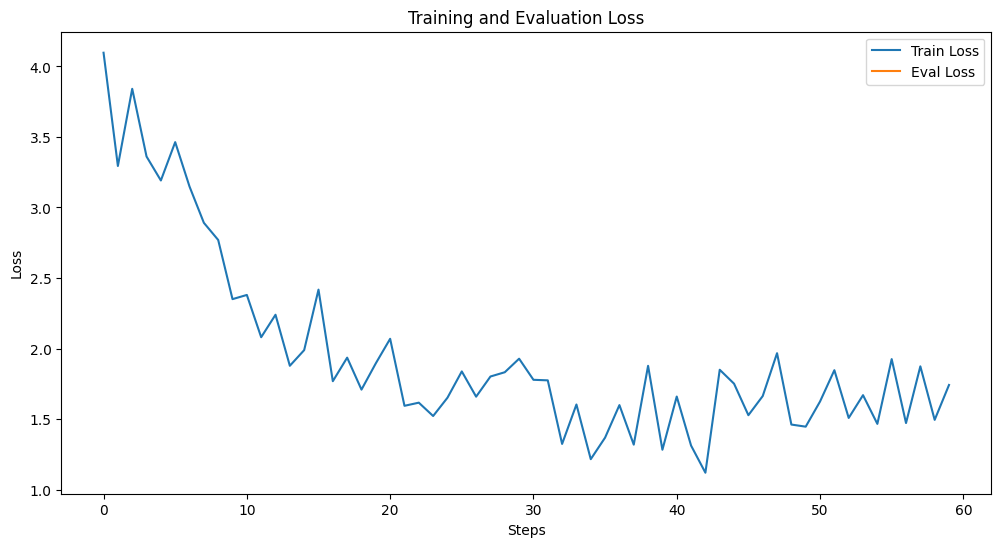

In [40]:
import matplotlib.pyplot as plt

# Plot training loss for train & eval sets
plt.figure(figsize=(12, 6))
plt.plot(callback.train_losses, label='Train Loss')
plt.plot(callback.eval_losses, label='Eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

# Teste do modelo treinado

Aqui realizamos as perguntas para verificar a diferença entre o antes e o depois do modelo treinado.

Verificamos aqui que as respostas do modelo ja fazem maior sentido em ralação a base de dados.

In [41]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "Describe the product [input]", # instruction
        "'The Way Things Work: An Illustrated Encyclopedia of Technology'", # input
        "", # output—leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the product [input]

### Input:
'The Way Things Work: An Illustrated Encyclopedia of Technology'

### Response:
The 'The Way Things Work: An Illustrated Encyclopedia of Technology' is A new, updated edition of the classic reference on technology and engineering, featuring 1,500 new images and 150 new pages.<|end_of_text|>


In [42]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "Describe the product [input]", # instruction
        "'Adult Ballet Tutu Yellow'", # input
        "", # output—leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the product [input]

### Input:
'Adult Ballet Tutu Yellow'

### Response:
The 'Adult Ballet Tutu Yellow' is A full-length tutu for ballet performances.<|end_of_text|>


In [43]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        "Describe the product [input]", # instruction
        "'Misty of Chincoteague'", # input
        "", # output—leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the product [input]

### Input:
'Misty of Chincoteague'

### Response:
The 'Misty of Chincoteague' is Margaret Wise Brown&#8217;s classic tale of a young girl&#8217;s quest to catch a wild pony on the Chincoteague Islands.<|end_of_text|>


# Salvamento do modelo em arquivo


In [44]:
model.save_pretrained("/content/drive/MyDrive/FIAP/Tech_CH_Fase3/lora_model") # Local saving
tokenizer.save_pretrained("/content/drive/MyDrive/FIAP/Tech_CH_Fase3/lora_model")

('/content/drive/MyDrive/FIAP/Tech_CH_Fase3/lora_model/tokenizer_config.json',
 '/content/drive/MyDrive/FIAP/Tech_CH_Fase3/lora_model/special_tokens_map.json',
 '/content/drive/MyDrive/FIAP/Tech_CH_Fase3/lora_model/tokenizer.json')